# Линейная регрессия
__Суммарное количество баллов: 10__


In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="./hw9_data/boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Ее и нужно реализовать.

In [4]:
def mse(y_true, y_predicted):
    return np.mean((y_true - y_predicted)**2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
from scipy.linalg import inv


class NormalLR:
    def __init__(self, l2_coef=0):
        self.l2_coef = l2_coef
    
    def fit(self, X, y):
        X = np.concatenate((X, np.ones((1, len(X))).T), axis=1)
        self.w = inv(X.T @ X + self.l2_coef * np.eye(X.shape[1])) @ X.T @ y  
    
    def predict(self, X):
        X = np.concatenate((X, np.ones((1, len(X))).T), axis=1)
        return X @ self.w

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR(0.3)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.011358954274211932


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

### Задание 4 (2 балла)
Добавьте в метод `fit` регуляризацию Лассо с коэффициентом `l`. Постройте график зависимости ошибки предсказания данных из синтетического набора данных от коэффициента регуляризации.

In [8]:
class GradientLR:
    def __init__(self, alpha, iterations=10000, l1=1, l2=0):
        self.alpha = alpha
        self.iterations = iterations
        self.l1 = l1
        self.l2 = l2
    
    def fit(self, X, y):
        X = np.concatenate((X, np.ones((1, len(X))).T), axis=1)
        self.w = np.random.randn(X.shape[1])
        
        for iter in range(self.iterations):
            self.w -= self.alpha * self.grad(X, y)

    def predict(self, X):
        X = np.concatenate((X, np.ones((1, len(X))).T), axis=1)
        return X @ self.w
    
    def grad(self, X, y):
        mse_grad = X.T @ (X @ self.w - y) * 2 / len(X)
        l1_grad = self.l1 * np.sign(self.w)
        l2_grad = self.l2 * 2 * self.w
        
        return mse_grad + l1_grad + l2_grad

In [48]:
def plot(title, y, y1=None, x=None, label1=None, label2=None, xlabel=None, ylabel=None):
    if x is None:
        x = [i for i in range(len(y))]
        
    fig = plt.figure()
    plt.figure(figsize=(16,6), dpi= 80)
    plt.title(title, fontsize=17)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)
    plt.grid(axis='both', alpha=.3)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.plot(x, y, color='tab:red',label=label1);
    if y1 is not None:
        plt.plot(x, y1, color='tab:purple',label=label2)
    plt.legend()
    plt.show();
    

def build_plot(X_train, y_train, X_test, y_test, l_log_min=-4.6, l_log_max=-2.6):
    mse_losses = []
    all_l = np.logspace(l_log_min, l_log_max, 400)
    for l1 in all_l:
        regr = GradientLR(0.1, iterations=1000, l1=l1)
        regr.fit(X_train, y_train)
        mse_losses.append(np.log(mse(y_test, regr.predict(X_test))))
    
    plot("Log mse losses according to parameter l", y=mse_losses, 
         x=all_l, xlabel="l",  ylabel="Log mse")

In [49]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

0.009292347042739185


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

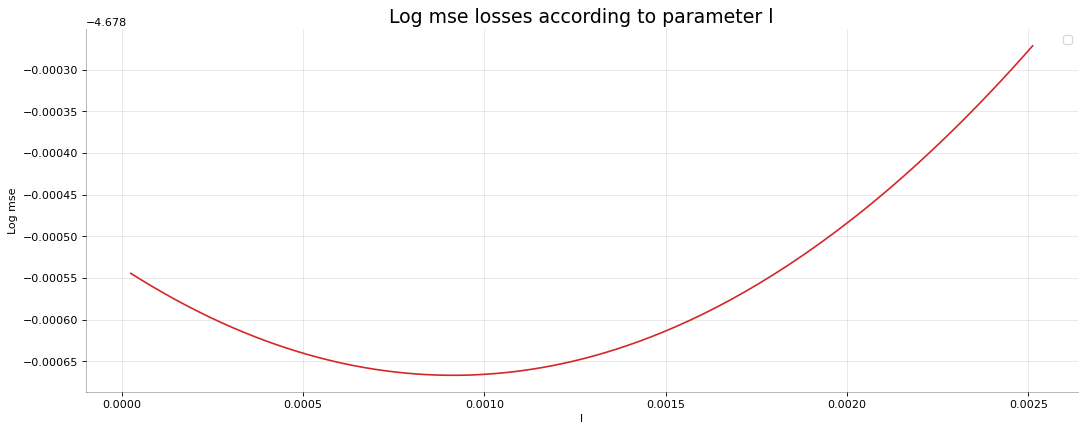

In [50]:
regr = GradientLR(0.1, iterations=10000, l1=1e-4)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)

### Задание 5 (2 балла)
Протесируйте оба метода на данных boston, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [12]:
from sklearn.preprocessing import StandardScaler

X, y = read_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

ss_scale = StandardScaler()
X_train = ss_scale.fit_transform(X_train)
X_test = ss_scale.transform(X_test)

In [13]:
regr = NormalLR(l2_coef=60)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

19642925.79335504


32799809.96829642


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

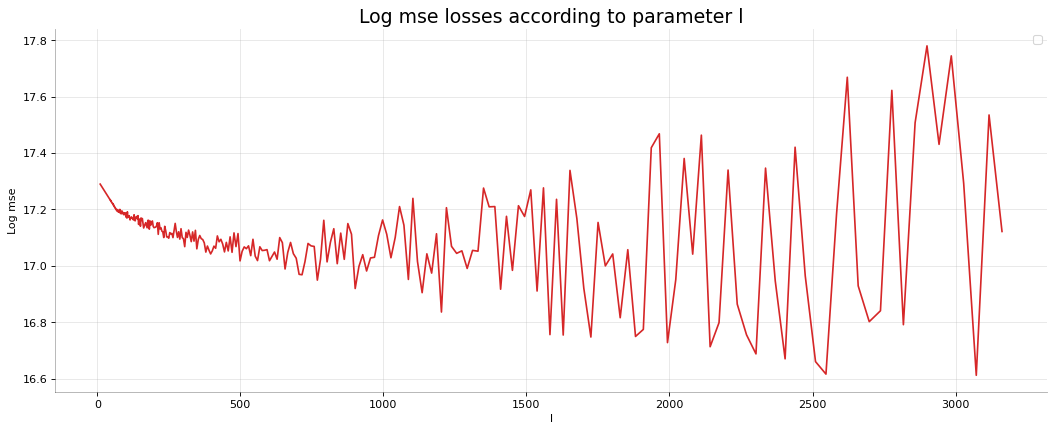

In [14]:
regr = GradientLR(0.1, iterations=10000, l1=1e-3)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test, l_log_min=1, l_log_max=3.5)

По идее 2 следующих метода должны давать похожий лосс, но это не выполняется. Почему? 

In [15]:
regr = GradientLR(0.1, l2=0.1)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

19631924.093746018


In [16]:
regr = NormalLR(l2_coef=0.1)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

32723264.75501283
